# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy


## Тут можно почитать про статью, либу и теорию:
Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues



# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [16]:
# # СНАЧАЛА ТРЕБУЕТСЯ УСТАНОВИТЬ БИБЛИОТЕКИ

# !pip install finrl library
# !pip install wrds
# !pip install swig
# !pip install -q condacolab
# !pip install yfinance
# !pip install stockstats
# !pip install stable-baselines3
# !pip install pyfolio-reloaded
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
# !pip install exchange_calendars
# !pip install tensorboard



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them.
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import time
import json
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

%matplotlib inline
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.main import check_and_make_directories
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from stable_baselines3.common.logger import configure
from finrl.config import INDICATORS


from stockstats import StockDataFrame as Sdf

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools
from sqlalchemy import create_engine, TIMESTAMP, JSON
import os
import zipfile
import torch
# import streamlit as st

## Import data from db

In [2]:
db_params = {
    'dbname': 'rl_trade',  # Имя вашей базы данных
    'user': 'bezzonov',     # Имя пользователя
    'password': 'bezzonov_rl_trade',  # Пароль пользователя
    'host': '46.17.100.206',         # Хост (например, localhost)
    'port': '5432'               # Порт (обычно 5432)
}

conn = create_engine(f'postgresql+psycopg2://{db_params["user"]}:{db_params["password"]}@{db_params["host"]}:{db_params["port"]}/{db_params["dbname"]}')


query = """
    SELECT *
    FROM shares_data order by time
"""
moex = pd.read_sql(query, conn)

moex.rename(columns={'time': 'date', 'ticker': 'tic'}, inplace=True)
moex= moex[['date',	'open',	'high',	'low',	'close', 'volume', 'tic']]

<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    TRAINED_MODEL_DIR,
    RESULTS_DIR,
    INDICATORS
)

check_and_make_directories([TRAINED_MODEL_DIR, RESULTS_DIR])

In [4]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(moex)
# processed = processed.copy()
# processed = processed.fillna(0)
# processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [5]:
TRAIN_START_DATE = min(processed.date)
TRAIN_END_DATE = max(processed.date) - pd.Timedelta(days=61)
TEST_START_DATE = max(processed.date) - pd.Timedelta(days=60)
TEST_END_DATE = max(processed.date)

train = data_split(processed, TRAIN_START_DATE, TRAIN_END_DATE+timedelta(days=1))
trade = data_split(processed, TEST_START_DATE, TEST_END_DATE)
print(len(train))
print(len(trade))

78342
1232


In [11]:
train

,date,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2015-04-30,39.440,39.440,37.440,38.440,594330.0,AFLT,0.000000,38.440000,38.440000,100.000000,0.000000,100.000000,38.440000,38.440000,0.000000
0,2015-04-30,69.280,69.280,67.280,68.280,399290.0,ALRS,0.000000,38.440000,38.440000,100.000000,0.000000,100.000000,68.280000,68.280000,0.000000
0,2015-04-30,570.000,579.000,561.000,578.000,960000.0,CHMF,0.000000,38.440000,38.440000,100.000000,0.000000,100.000000,578.000000,578.000000,0.000000
0,2015-04-30,152.540,154.540,151.540,153.540,2872334.0,GAZP,0.000000,38.440000,38.440000,100.000000,0.000000,100.000000,153.540000,153.540000,0.000000
0,2015-04-30,0.580,0.580,0.580,0.580,447230.0,HYDR,0.000000,38.440000,38.440000,100.000000,0.000000,100.000000,0.580000,0.580000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3560,2025-01-27,280.720,280.720,275.720,275.720,3903561.0,SBER,3.102894,285.131582,274.178418,56.457665,-13.951167,3.794100,278.240333,260.116833,24.275583
3560,2025-01-27,280.220,280.220,274.220,274.220,374876.0,SBERP,2.981863,285.541998,273.427002,55.195581,-43.620785,10.162624,278.121000,260.166333,24.275583
3560,2025-01-27,28.500,28.500,27.500,27.500,1012338.0,SNGS,1.134535,29.715398,21.402602,58.788679,133.561333,68.799864,25.205667,24.336667,24.275583
3560,2025-01-27,58.405,58.405,57.405,57.405,1142610.0,SNGSP,-0.062152,59.316600,56.706400,48.127073,-66.771723,26.121852,58.828333,57.734083,24.275583


In [10]:
trade

,date,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2025-01-28,60.150,61.150,58.150,61.150,3546399.0,AFLT,0.972352,62.721602,59.427398,57.434965,-4.469574,2.513763,60.344333,56.046833,14.050773
0,2025-01-28,54.980,55.980,54.980,55.980,3230809.0,ALRS,-0.008821,60.028608,53.343392,54.248969,-60.679821,7.438156,56.652333,53.105000,14.050773
0,2025-01-28,1225.400,1260.400,1203.400,1259.400,1043813.0,CHMF,0.754630,1338.496264,1213.563736,52.741057,-129.240443,6.880476,1286.973333,1202.046667,14.050773
0,2025-01-28,134.300,138.300,132.300,137.300,7461787.0,GAZP,2.757518,144.068673,124.977327,57.973854,53.358798,1.326407,133.213333,125.378167,14.050773
0,2025-01-28,0.533,0.533,0.533,0.533,210407.0,HYDR,0.009438,0.561444,0.506806,54.549923,28.016789,6.381177,0.527660,0.502103,14.050773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,2025-03-28,311.960,313.960,305.960,308.960,5187687.0,SBER,1.340578,328.413222,309.630778,51.992483,-104.734051,32.187730,316.539000,305.140833,60.181910
55,2025-03-28,309.000,311.000,303.000,306.000,540285.0,SBERP,1.185809,324.496143,307.297857,51.379500,-120.223383,34.760190,313.834333,303.352667,60.181910
55,2025-03-28,26.165,26.165,25.165,25.165,566787.0,SNGS,-0.370094,27.801272,25.022228,45.451108,-115.805452,18.230116,26.990833,27.583583,60.181910
55,2025-03-28,54.000,54.000,53.000,54.000,3686550.0,SNGSP,-0.577331,55.916914,53.226586,44.414172,-102.289650,23.838828,55.431667,56.890750,60.181910


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [8]:
stock_dimension = len(train.tic.unique())
state_space =  len(INDICATORS)*stock_dimension + 1 + 2*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()

Stock Dimension: 22, State Space: 221


In [9]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_trade_gym = StockTradingEnv(df=trade, turbulence_threshold = 70, **env_kwargs)

Stock Dimension: 22, State Space: 221


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [10]:
# model_comp = pd.DataFrame(columns=['date_model_init', 'model_name', 'train_data_params', 'test_data_params', 'total_timesteps',
#                                    'model_kwargs', 'policy_kwargs', 'train_time', 'test_time', 'balance_diff_rub', 'balance_diff_%'])

# DRL models train & test

In [10]:
# def DRL_prediction(model, environment, deterministic=True):
#         """make a prediction and get results"""
#         test_env, test_obs = environment.get_sb_env()
#         account_memory = None  # This help avoid unnecessary list creation
#         actions_memory = None  # optimize memory consumption
#         # state_memory=[] #add memory pool to store states

#         test_env.reset()
#         max_steps = len(environment.df.index.unique()) - 1

#         for i in range(len(environment.df.index.unique())):
#             action, _states = model.predict(test_obs, deterministic=deterministic)
#             # account_memory = test_env.env_method(method_name="save_asset_memory")
#             # actions_memory = test_env.env_method(method_name="save_action_memory")
#             test_obs, rewards, dones, info = test_env.step(action)

#             if (
#                 i == max_steps - 1
#             ):  # more descriptive condition for early termination to clarify the logic
#                 account_memory = test_env.env_method(method_name="save_asset_memory")
#                 actions_memory = test_env.env_method(method_name="save_action_memory")
#             # add current state to state memory
#             # state_memory=test_env.env_method(method_name="save_state_memory")

#             if dones[0]:
#                 print("hit end!")
#                 break
#         return account_memory[0], actions_memory[0]

In [11]:
def train_model(env_train, model_name, model_kwargs, policy_kwargs, total_timesteps):

    start_time = datetime.now()

    agent = DRLAgent(env = env_train)
    model = agent.get_model(f"{model_name}", model_kwargs=model_kwargs, policy_kwargs=policy_kwargs)

    date_model_init = datetime.now()
    trained_model = agent.train_model(model=model,
                                    tb_log_name=f"{model_name}",
                                    total_timesteps=total_timesteps)

    tmp_path = RESULTS_DIR + f'/{model_name}'
    new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    model.set_logger(new_logger)

    trained_model.save(TRAINED_MODEL_DIR + f"/agent_{model_name}")

    end_time = datetime.now()
    func_time = end_time - start_time

    return date_model_init, model_name, trained_model, total_timesteps, model_kwargs, policy_kwargs, func_time
# TO ZIP

# FROM ZIP TO MONEY
def model_predict(e_trade_gym, trained_model, balance_start):

    start_time = datetime.now()

    # load model (optional) for example
    # trained_a2c = A2C.load("trained_models/agent_a2c")

    df_account_value, df_actions = DRLAgent.DRL_prediction(
                                            model=trained_model,
                                            environment=e_trade_gym)

    df_result = df_account_value.set_index(df_account_value.columns[0])
    balance_finish = round(df_result.iloc[-1].values[0])

    balance_diff_rub = balance_finish - balance_start
    balance_diff_perc = (balance_finish - balance_start) / balance_start

    end_time = datetime.now()
    func_time = end_time - start_time

    return func_time, balance_diff_rub, balance_diff_perc, df_account_value, df_actions


def model_compare_append(info_to_append, path_to_file):

    model_comp = pd.read_csv(fr"{path_to_file}\rl_trade_agent\data\model_comp.csv")
    model_comp.loc[len(model_comp)] = info_to_append
    model_comp.to_csv(fr"{path_to_file}\rl_trade_agent\data\model_comp.csv", index=False)

    return model_comp


def start_pipeline(env_train, model_name, model_kwargs, policy_kwargs, total_timesteps, e_trade_gym, balance_start, path_to_file):
    # TRAIN MODEL
    date_model_init, model_name, trained_model, total_timesteps, model_kwargs, policy_kwargs, train_time = train_model(env_train, model_name, model_kwargs, policy_kwargs, total_timesteps)

    # TEST MODEL
    test_time, balance_diff_rub, balance_diff_perc, df_account_value, df_actions = model_predict(e_trade_gym, trained_model, balance_start)

    # FIX MODEL
    model_comp = model_compare_append([date_model_init.strftime("%Y-%m-%d %H:%M:%S"), model_name,
                      f'{len(train)} rows, {train.tic.nunique()} tickers, {min(train.date)} starts',
                      f'{len(trade)} rows, {trade.tic.nunique()} tickers, {min(trade.date)} starts',
                      total_timesteps, model_kwargs, policy_kwargs, f'{train_time.seconds}s', f'{test_time.seconds}s',
                      balance_diff_rub, round(100 * balance_diff_perc, 2)
                      ], path_to_file)

    return df_account_value, df_actions, model_comp


In [23]:
# A2C
model_name_a2c = 'a2c'
model_kwargs_a2c = {'learning_rate':0.05, 'ent_coef': 0.01, 'gae_lambda':0.95,
                    'gamma':0.98, 'max_grad_norm':0.49, 'n_steps':4, 'normalize_advantage':True}
policy_kwargs_a2c = {'optimizer_kwargs': {'alpha': 0.90, 'eps': 1e-04, 'weight_decay': 0}}

# DDPG
model_name_ddpg = 'ddpg'
model_kwargs_ddpg= {'batch_size':128, 'buffer_size':50000, 'gamma':0.99, 'gradient_steps':2,
                    'learning_rate':0.01, 'learning_starts':500, 'tau':0.003, 'optimize_memory_usage': False}
policy_kwargs_ddpg={'n_critics': 1}

# PPO
model_name_ppo = 'ppo'
model_kwargs_ppo = {'batch_size':64, 'ent_coef':0.02, 'gae_lambda':0.95, 'gamma':0.99,
                    'learning_rate':0.003, 'max_grad_norm':0.5, 'n_epochs':10, 'n_steps':2048,
                    'normalize_advantage':True, 'sde_sample_freq':-1, 'vf_coef':0.5}
policy_kwargs_ppo={}

# TD3
model_name_td3 = 'td3'
model_kwargs_td3 = {'batch_size':100, 'buffer_size':50000, 'gamma':0.99, 'learning_rate':0.001,
                    'learning_starts':100, 'optimize_memory_usage':True, 'tau':0.005 }
policy_kwargs_td3={}

# SAC
model_name_sac = 'sac'
model_kwargs_sac = {"batch_size": 128, "buffer_size": 100000, 'gamma':0.99,
                    'gradient_steps':2, "learning_rate": 0.0001, "learning_starts": 100,
                    'optimize_memory_usage':False, "ent_coef": "auto_0.1", 'tau':0.005,
                    'target_entropy':-20, 'sde_sample_freq':-1}
policy_kwargs_sac = {'use_sde': False}


total_timesteps = 10000
balance_start = env_kwargs['initial_amount']
path_to_file = r'C:\Users\besso\Desktop\rl'

df_account_value, df_actions, model_comp = start_pipeline(env_train,
                                                          # ENTER MODEL PARAMS
                                                          model_name_a2c, model_kwargs_a2c, policy_kwargs_a2c,
                                                          ####
                                                          total_timesteps,
                                                          e_trade_gym,
                                                          balance_start,
                                                          path_to_file)

{'learning_rate': 0.05, 'ent_coef': 0.01, 'gae_lambda': 0.95, 'gamma': 0.98, 'max_grad_norm': 0.49, 'n_steps': 4, 'normalize_advantage': True}
Using cpu device
-------------------------------------
| time/                 |           |
|    fps                | 44        |
|    iterations         | 100       |
|    time_elapsed       | 8         |
|    total_timesteps    | 400       |
| train/                |           |
|    entropy_loss       | -35.4     |
|    explained_variance | -0.00268  |
|    learning_rate      | 0.05      |
|    n_updates          | 99        |
|    policy_loss        | -1.26     |
|    reward             | -0.157726 |
|    std                | 2.1       |
|    value_loss         | 0.172     |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 45       |
|    iterations         | 200      |
|    time_elapsed       | 17       |
|    total_timesteps    | 800      |
| train/  

In [14]:
model_comp

,date_model_init,model_name,train_data_params,test_data_params,total_timesteps,model_kwargs,policy_kwargs,train_time,test_time,balance_diff_rub,balance_diff_%
0,2025-03-30 12:28:12,a2c,"79310 rows, 22 tickers, 2015-04-30 00:00:00 st...","264 rows, 22 tickers, 2025-03-15 00:00:00 starts",10000,"{'learning_rate': 0.01, 'ent_coef': 0.01, 'gae...","{'optimizer_kwargs': {'alpha': 0.99, 'eps': 1e...",199s,0s,-35832,-3.58
1,2025-03-30 12:51:50,a2c,"79310 rows, 22 tickers, 2015-04-30 00:00:00 st...","264 rows, 22 tickers, 2025-03-15 00:00:00 starts",10000,"{'learning_rate': 0.01, 'ent_coef': 0.01, 'gae...","{'optimizer_kwargs': {'alpha': 0.99, 'eps': 1e...",175s,0s,-78438,-7.84
2,2025-03-30 13:07:28,a2c,"79002 rows, 22 tickers, 2015-04-30 00:00:00 st...","572 rows, 22 tickers, 2025-02-27 00:00:00 starts",10000,"{'learning_rate': 0.01, 'ent_coef': 0.01, 'gae...","{'optimizer_kwargs': {'alpha': 0.99, 'eps': 1e...",170s,0s,-92731,-9.27
3,2025-03-30 13:13:10,a2c,"79002 rows, 22 tickers, 2015-04-30 00:00:00 st...","572 rows, 22 tickers, 2025-02-27 00:00:00 starts",10000,"{'learning_rate': 0.01, 'ent_coef': 0.01, 'gae...","{'optimizer_kwargs': {'alpha': 0.99, 'eps': 1e...",204s,0s,-52038,-5.20
4,2025-03-30 13:34:50,a2c,"79002 rows, 22 tickers, 2015-04-30 00:00:00 st...","572 rows, 22 tickers, 2025-02-27 00:00:00 starts",10000,"{'learning_rate': 0.02, 'ent_coef': 0.01, 'gae...","{'optimizer_kwargs': {'alpha': 0.99, 'eps': 1e...",215s,0s,-70819,-7.08
5,2025-03-30 14:07:35,a2c,"79002 rows, 22 tickers, 2015-04-30 00:00:00 st...","572 rows, 22 tickers, 2025-02-27 00:00:00 starts",10000,"{'learning_rate': 0.05, 'ent_coef': 0.01, 'gae...","{'optimizer_kwargs': {'alpha': 0.99, 'eps': 1e...",180s,0s,-130703,-13.07
6,2025-03-30 14:13:27,a2c,"79002 rows, 22 tickers, 2015-04-30 00:00:00 st...","572 rows, 22 tickers, 2025-02-27 00:00:00 starts",10000,"{'learning_rate': 0.05, 'ent_coef': 0.01, 'gae...","{'optimizer_kwargs': {'alpha': 0.99, 'eps': 1e...",181s,0s,-64904,-6.49
7,2025-03-30 18:34:14,a2c,"79002 rows, 22 tickers, 2015-04-30 00:00:00 st...","572 rows, 22 tickers, 2025-02-27 00:00:00 starts",50000,"{'learning_rate': 0.05, 'ent_coef': 0.01, 'gae...","{'optimizer_kwargs': {'alpha': 0.99, 'eps': 1e...",1080s,0s,-93007,-9.30
8,2025-03-30 19:00:22,a2c,"79002 rows, 22 tickers, 2015-04-30 00:00:00 st...","572 rows, 22 tickers, 2025-02-27 00:00:00 starts",10000,"{'learning_rate': 0.05, 'ent_coef': 0.01, 'gae...","{'optimizer_kwargs': {'alpha': 0.99, 'eps': 1e...",215s,0s,-51613,-5.16
9,2025-03-30 19:35:31,a2c,"79002 rows, 22 tickers, 2015-04-30 00:00:00 st...","572 rows, 22 tickers, 2025-02-27 00:00:00 starts",10000,"{'learning_rate': 0.05, 'ent_coef': 0.01, 'gae...","{'optimizer_kwargs': {'alpha': 0.99, 'eps': 1e...",249s,0s,-83460,-8.35


In [41]:
def trades_history(df_account_value, df_actions):

    action_dict = {}
    shares_dict = {}
    share_assets_dict = {}

    for date, row in df_actions.iterrows():
        non_zero_values = {col: [val, val * trade['close'][(trade['date'] == date) & (trade['tic'] == col)].values[0]] for col, val in row.items() if val != 0}
        if non_zero_values:
            action_dict[date] = non_zero_values
        else:
            action_dict[date] = np.nan
    action_dict[max(df_account_value['date'])] = np.nan
    action_dict_df = pd.DataFrame(list(action_dict.items()), columns=['date', 'actions'])

    for k, v in action_dict.items():
        if k == df_account_value['date'].values[0] and pd.isna(v):
            continue
        elif k == df_account_value['date'].values[0] and not pd.isna(v):
            shares_dict[k] = {share:[quanity[0], quanity[0]*trade['close'][(trade['date'] == k) & (trade['tic'] == share)].values[0]] for share, quanity in v.items()}
        elif pd.isna(v) and len(shares_dict) != 0:
            shares_dict[k] = {share:[quanity[0], quanity[0]*trade['close'][(trade['date'] == k) & (trade['tic'] == share)].values[0]] for share,quanity in sorted(shares_dict.items(), key=lambda x: x[0])[-1][1].items()}
        elif pd.isna(v) and len(shares_dict) == 0:
            continue
        else:
            if len(shares_dict) != 0:
                first_dict = {share:quanity[0] for share,quanity in sorted(shares_dict.items(), key=lambda x: x[0])[-1][1].items()}
                second_dict = {share:price[0] for share, price in v.items()}
                share_quanity_dict = {key: first_dict.get(key, 0) + second_dict.get(key, 0) for key in set(first_dict) | set(second_dict) if first_dict.get(key, 0) + second_dict.get(key, 0) != 0}
                shares_dict[k] = {share:[quanity, quanity*trade['close'][(trade['date'] == k) & (trade['tic'] == share)].values[0]] for share, quanity in share_quanity_dict.items()}
            elif len(shares_dict) == 0:
                shares_dict[k] = {share:[quanity[0], quanity[0]*trade['close'][(trade['date'] == k) & (trade['tic'] == share)].values[0]] for share, quanity in v.items()}
    share_dict_df = pd.DataFrame(list(shares_dict.items()), columns=['date', 'portfolio'])

    for k, v in shares_dict.items():
        share_assets_dict[k] = sum([asset[-1] for asset in v.values()])
    share_assets_dict_df = pd.DataFrame(list(share_assets_dict.items()), columns=['date', 'share_assets'])


    trade_id = 897156
    trades_history = df_account_value
    trades_history['id'] = [118 + i for i in range(len(df_account_value))]
    trades_history['trade_id'] = trade_id
    trades_history = trades_history.merge(action_dict_df, how='left', on='date')
    trades_history = trades_history.merge(share_dict_df, how='left', on='date')
    trades_history = trades_history.merge(share_assets_dict_df, how='left', on='date')
    trades_history['free_assets'] = trades_history['account_value'] - trades_history['share_assets']
    trades_history = trades_history[['date', 'id', 'trade_id', 'account_value', 'share_assets', 'free_assets', 'actions', 'portfolio']]

    trades_history['account_value'] = trades_history['account_value'].apply(lambda x: round(x, 2))
    trades_history['share_assets'] = trades_history['share_assets'].apply(lambda x: round(x, 2))
    trades_history['free_assets'] = trades_history['free_assets'].apply(lambda x: round(x, 2))


    trades_history['actions'] = trades_history['actions'].apply(lambda x: json.dumps(x))
    trades_history['portfolio'] = trades_history['portfolio'].apply(lambda x: json.dumps(x))

    trades_history.to_sql('trades_history', con=conn, if_exists='append', index=False, dtype={'date': TIMESTAMP, 'actions':JSON, 'portfolio':JSON})

    return trades_history

x = trades_history(df_account_value, df_actions)

In [19]:
df_account_value

,date,account_value,id,trade_id
0,2025-01-28,1.000000e+06,60,897157
1,2025-01-29,1.001382e+06,61,897157
2,2025-01-30,1.010682e+06,62,897157
3,2025-01-31,1.002339e+06,63,897157
4,2025-02-01,1.002339e+06,64,897157
5,2025-02-02,1.002339e+06,65,897157
6,2025-02-03,9.928545e+05,66,897157
7,2025-02-04,9.869548e+05,67,897157
8,2025-02-05,1.007447e+06,68,897157
9,2025-02-06,1.007131e+06,69,897157


In [49]:
# trained_a2c = A2C.load("trained_models/agent_a2c")
# trained_ddpg = DDPG.load("trained_models/agent_ddpg")
# trained_ppo = PPO.load("trained_models/agent_ppo")
# trained_td3 = TD3.load("trained_models/agent_td3")
# trained_sac = SAC.load("trained_models/agent_sac")

In [38]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, **env_kwargs)

Stock Dimension: 22, State Space: 221


In [39]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym)


df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym)

df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym)

df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment = e_trade_gym)

df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment = e_trade_gym)

hit end!
hit end!
hit end!
hit end!
hit end!


In [40]:

def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

def StockReturnsComputing(StockPrice, Rows, Columns):
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

In [41]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

array([[   56.82 ,    52.65 ,    10.564,  1148.2  ,   119.18 ,     0.507,
            3.803,  6919.   ,    34.145,  4984.5  ,   189.2  ,   193.1  ,
          134.1  ,   944.   ,  6297.   ,   471.   , 13929.   ,   569.   ,
           58.55 ,   264.   ,    24.15 ,   636.   ],
       [   53.1  ,    52.3  ,     9.25 ,  1135.   ,   121.97 ,     0.509,
            3.739,  6833.   ,    33.705,  4945.5  ,   186.95 ,   194.5  ,
          133.   ,   915.8  ,  6391.   ,   444.   , 13719.   ,   572.5  ,
           57.75 ,   264.94 ,    23.12 ,   625.   ],
       [   54.56 ,    52.97 ,     9.4  ,  1161.   ,   128.71 ,     0.495,
            3.673,  6987.   ,    34.845,  5027.   ,   196.7  ,   196.75 ,
          135.8  ,   929.   ,  6368.   ,   454.   , 13973.   ,   581.65 ,
           58.69 ,   271.62 ,    23.63 ,   629.   ],
       [   55.96 ,    54.3  ,    10.77 ,  1174.4  ,   126.4  ,     0.503,
            3.722,  7003.   ,    34.8  ,  5174.   ,   194.7  ,   196.   ,
          133.58 ,   949.  

In [42]:
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [-0.003 -0.016  0.225  0.037  0.012  0.078  0.263  0.041  0.014  0.045
  0.071  0.007  0.014  0.013  0.072  0.042  0.093  0.046  0.006  0.047
  0.043  0.015]
Variance-Covariance matrix of returns
 [[ 7.419  2.38   1.353  2.3    2.351  0.286  3.023  2.244  2.19   2.595
   1.996  2.364  2.553  2.314  0.387  2.128  1.188  2.741  1.846  3.245
   2.899  2.606]
 [ 2.38   5.145  1.593  2.101  2.5    0.333  1.911  2.198  2.25   2.227
   1.934  1.71   2.34   2.683  1.36   1.885  1.5    2.676  1.791  2.698
   2.549  2.655]
 [ 1.353  1.593 37.444  1.062  1.635  1.023  1.846  1.373  1.993  0.82
   1.417  1.174  1.35   1.809  0.598  1.832  0.839  1.688  1.24   2.029
   0.8    1.55 ]
 [ 2.3    2.101  1.062  4.434  2.173  0.311  2.205  1.899  3.095  2.194
   1.86   1.766  3.38   2.219  0.772  2.031  1.501  2.437  1.749  2.569
   2.389  2.297]
 [ 2.351  2.5    1.635  2.173  6.04   0.464  2.246  2.718  1.997  2.443
   1.875  1.87   2.222  2.641  1.136  1.725  1.

In [43]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(len(cleaned_weights_mean))])
mvo_weights

array([     0.,      0., 130960.,      0.,      0.,  69070., 108730.,
            0.,      0.,      0., 123570.,      0.,      0.,      0.,
       308590.,      0., 259070.,      0.,      0.,      0.,      0.,
            0.])

In [44]:

LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([     0.   ,      0.   ,  13894.96 ,      0.   ,      0.   ,
       148601.549,  29752.36 ,      0.   ,      0.   ,      0.   ,
          656.589,      0.   ,      0.   ,      0.   ,     53.077,
            0.   ,     19.049,      0.   ,      0.   ,      0.   ,
            0.   ,      0.   ])

In [45]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var Optimization"])
MVO_result.tail(5)

,Mean Var Optimization
2025-02-14,1.200220e+06
2025-02-17,1.231686e+06
2025-02-18,1.218191e+06
2025-02-19,1.218056e+06
2025-02-20,1.218318e+06


In [46]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])

result = pd.DataFrame()

result = pd.merge(result, df_result_a2c.rename(columns={'account_value':'A2C value'}), how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ddpg.rename(columns={'account_value':'DDPG value'}), how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo.rename(columns={'account_value':'PPO value'}), how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_td3.rename(columns={'account_value':'TD3 value'}), how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_sac.rename(columns={'account_value':'SAC value'}), how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)

col_name = []
col_name.append('A2C')
col_name.append('DDPG')
col_name.append('PPO')
col_name.append('TD3')
col_name.append('SAC')
col_name.append('MVO')

result['Mean Var Optimization'] = result['Mean Var Optimization'] - 59035
result

,A2C value,DDPG value,PPO value,TD3 value,SAC value,Mean Var Optimization
date,,,,,,
2024-12-23,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000001e+06
2024-12-24,9.867329e+05,9.871063e+05,9.984333e+05,9.838990e+05,1.006327e+06,9.796327e+05
2024-12-25,9.952924e+05,1.003347e+06,1.002581e+06,1.001833e+06,1.010674e+06,9.877220e+05
2024-12-26,1.006534e+06,1.022980e+06,1.004567e+06,1.005075e+06,1.008218e+06,1.002878e+06
2024-12-27,1.017050e+06,1.030469e+06,1.008303e+06,1.014855e+06,1.026833e+06,9.880542e+05
2024-12-28,9.957704e+05,1.022170e+06,1.025971e+06,1.009272e+06,1.009762e+06,9.909319e+05
2024-12-30,1.014139e+06,1.062531e+06,1.070770e+06,1.027118e+06,1.020523e+06,1.014687e+06
2025-01-03,9.967617e+05,1.037794e+06,1.046713e+06,1.026491e+06,1.006059e+06,9.891163e+05
2025-01-06,9.896475e+05,1.030778e+06,1.048724e+06,1.025606e+06,1.001479e+06,1.011183e+06


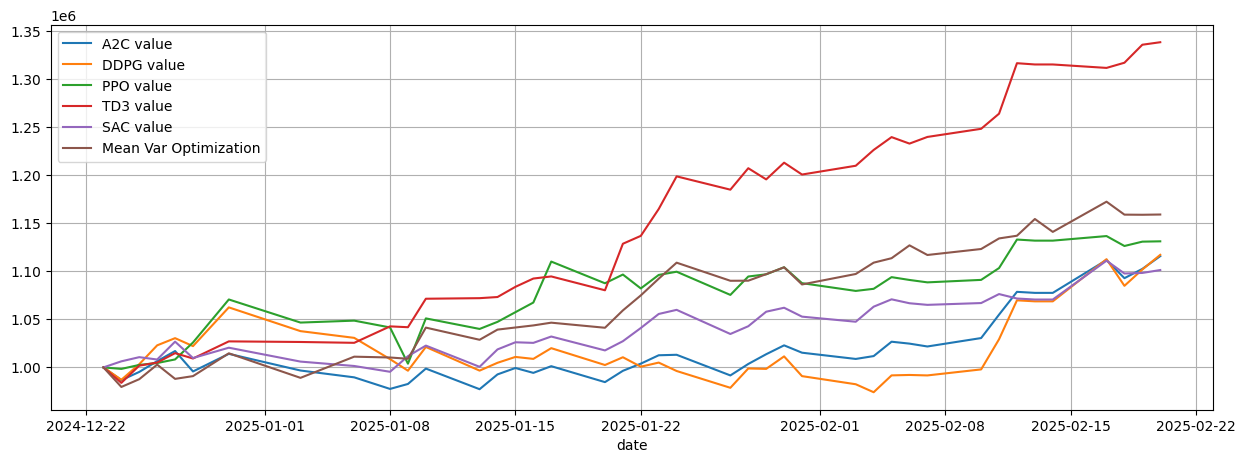

In [47]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 5)
result.plot()
plt.grid()
plt.show()